## Part 1: Install the Environment

## Main Code

In [7]:
import mujoco_py
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Creat an actor network

In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

### Create a critic network

In [9]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
class A3C:
    def __init__(self, state_dim, action_dim, learning_rate, gamma):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=learning_rate)
        self.mse_loss = nn.MSELoss()
        self.gamma = gamma

    def train(self, env, num_episodes, max_timesteps):
        total_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            state = state[0]
            state = torch.FloatTensor(state).unsqueeze(0)
            done = False
            total_reward = 0

            for t in range(max_timesteps):
                try:
                    action_mean = self.actor(state)
                    action_std = torch.ones_like(action_mean) * 0.5  # 使用固定的标准差
                    action_dist = torch.distributions.Normal(action_mean, action_std)
                    action = action_dist.sample().clamp(env.action_space.low[0], env.action_space.high[0])  # 截断动作以符合Hopper-v4环境的动作空间
                    next_state, reward, done, _ , _= env.step(action.numpy()[0])
                    next_state = torch.FloatTensor(next_state).unsqueeze(0)
                    reward = torch.FloatTensor([reward]).unsqueeze(0)

                    value = self.critic(state)
                    next_value = self.critic(next_state)
                    target = reward + self.gamma * next_value * (1 - done)
                    advantage = target - value

                    # 处理 NaN 问题
                    if torch.isnan(advantage).any() or torch.isnan(target).any():
                        print("NaN detected in training, skipping this step.")
                        continue

                    critic_loss = self.mse_loss(value, target.detach())
                    actor_loss = -(action_dist.log_prob(action).sum() * advantage.detach())

                    self.actor_optimizer.zero_grad()
                    self.critic_optimizer.zero_grad()
                    actor_loss.backward()
                    critic_loss.backward()

                    # 添加梯度裁剪
                    torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
                    torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)

                    self.actor_optimizer.step()
                    self.critic_optimizer.step()

                    state = next_state
                    total_reward += reward.item()

                    if done:
                        break
                except Exception as e:
                    print(f"Error at timestep {t} in episode {episode}: {e}")
                    break

            total_rewards.append(total_reward)
            if (episode + 1) % 20 == 0:  # 每100个episode打印一次
                print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        return total_rewards


### Plotting total rewards

In [21]:
env = gym.make('HalfCheetah-v4', ctrl_cost_weight=0.1, reset_noise_scale=1e-3)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
learning_rate = 3e-4
gamma = 0.95
episodes = 200
max_timesteps = 1000

a3c = A3C(state_dim, action_dim, learning_rate, gamma)
rewards = a3c.train(env, episodes, max_timesteps)



Episode 20, Total Reward: -221.43386116088368
Episode 40, Total Reward: -74.88716776960064
Episode 60, Total Reward: -117.98771350282186
Episode 80, Total Reward: -7.311622491164599
Episode 100, Total Reward: -39.96429795527365
Episode 120, Total Reward: -95.37946739338804
Episode 140, Total Reward: 0.963237686723005
Episode 160, Total Reward: -36.336615111737046
Episode 180, Total Reward: 64.21524720091838
Episode 200, Total Reward: -62.936928732378874


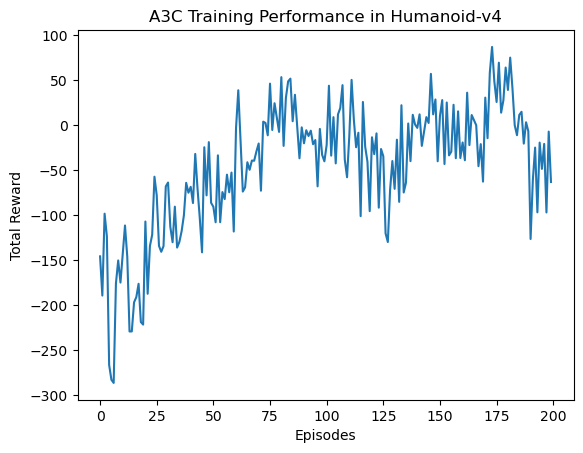

In [22]:
# 可视化训练结果
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('A3C Training Performance in Humanoid-v4')
plt.show()